# How well do the number of bedrooms/bathrooms and square feet predict the tax-assessed value of single-unit residential properties in three Southern California counties during from May to June 2017?

#### Sean Oslin
#### October 21, 2019

## Project planning phase

### Project goal/research question

To predict the values of single-unit properties that the tax district assesses using the property data from those whose last transaction was during the "hot months" (in terms of real estate demand) of May and June in 2017.

### Deliverables

1. Presentation of the analysis findings usable by management for decision making
2. MySQL notebook with database queries that were imported into Python for analysis
3. Data definitions and analysis notes
4. Data analysis in a Jupyter Notebook that will allow for replication of analysis
5. Github repository holding the analysis and supporting materials

### Minimum viable product

Analysis of how 3 variables (bedroom count, bathroom count and square feet), singlely and in combination predict the tax assessment value for three counties in Southern California as compared to the baseline.

### Null and alternative hypotheses

H<sub>0</sub> : The number of bathrooms, bedrooms and number of square feet in a single-unit residence do not predict the assessed tax value

H<sub>a</sub> : The number of bathrooms, bedrooms and number of square feet in a single-unit residence predict the assessed tax value

## Data acquisition and preparation phases

The sole data source was the Zillow relational database. Data was cleaned and prepared using MySQL and then uploaded to Python for additional preparation and analysis. For detailed information on data preparation please see.........

### Python libraries used for analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.linear_model import LinearRegression
from math import sqrt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

### Python programming for this analysis imported from a text editor

In [2]:
import env
import wrangle_z
import z_split_scale

### Import of prepared Zillow data from the text editor to this notebook

In [3]:
df_z = wrangle_z.wrangle_zillow()

### Verification that all null values have been removed

In [4]:
df_z.isnull().sum()

Property Description    0
Number of Bathrooms     0
Number of Bedrooms      0
Square Feet             0
Tax Appraised Value     0
Assessed Tax            0
County Number           0
dtype: int64

### Data types adjusted to best suit each variable

In [5]:
df_z['County Number'] = df_z['County Number'].astype('int64')
df_z['Tax Appraised Value'] = df_z['Tax Appraised Value'].astype('int64')
df_z['Square Feet'] = df_z['Square Feet'].astype('int64')
df_z['Number of Bedrooms'] = df_z['Number of Bedrooms'].astype('int64')

### Summary of data types, numbers of rows (individual real estate properties) and data columns

In [6]:
df_z.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15963 entries, 0 to 15962
Data columns (total 7 columns):
Property Description    15963 non-null object
Number of Bathrooms     15963 non-null float64
Number of Bedrooms      15963 non-null int64
Square Feet             15963 non-null int64
Tax Appraised Value     15963 non-null int64
Assessed Tax            15963 non-null float64
County Number           15963 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 997.7+ KB


## Data exploration and pre-processing phases

### Random sample of data

In [7]:
df_z.sample(4)

,Property Description,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number
12010,Single Family Residential,2.0,4,1610,116499,2177.67,6037
6275,Single Family Residential,2.0,3,1485,551000,6871.88,6037
13781,Single Family Residential,1.0,2,1436,200853,2215.43,6037
13194,Single Family Residential,2.0,3,1362,245877,3226.81,6037


### Descriptive statistics

In [8]:
df_z.describe()

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number
count,15963.000000,15963.000000,15963.000000,1.596300e+04,15963.000000,15963.000000
mean,2.215749,3.252835,1837.059199,4.633165e+05,5680.536779,6044.516758
std,1.026447,0.949797,984.656553,6.432976e+05,7465.277971,17.335701
min,1.000000,1.000000,320.000000,1.216800e+04,49.180000,6037.000000
25%,2.000000,3.000000,1233.000000,1.820635e+05,2495.545000,6037.000000
50%,2.000000,3.000000,1592.000000,3.204320e+05,4063.980000,6037.000000
75%,3.000000,4.000000,2162.500000,5.284255e+05,6408.970000,6037.000000
max,20.000000,25.000000,26345.000000,1.912982e+07,228999.210000,6111.000000


### Median values - mean and median values for bathrooms, bedrooms and square footage are close in value, allowing for an assumption of normality

In [9]:
df_z.median()

Number of Bathrooms         2.00
Number of Bedrooms          3.00
Square Feet              1592.00
Tax Appraised Value    320432.00
Assessed Tax             4063.98
County Number            6037.00
dtype: float64

### Visualizations of the data set

#### Distribution of the number of bathrooms by assessed tax - there are significant outliers for assessed taxes for houses with mean number of bathrooms

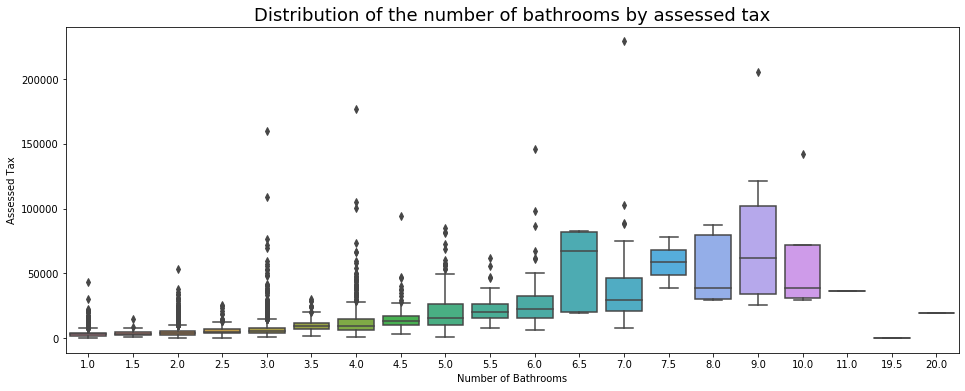

In [10]:
plt.figure(figsize=(16, 6))
ax1 = sns.boxplot(x=df_z["Number of Bathrooms"], y=df_z["Assessed Tax"], data=df_z)\
.set_title('Distribution of the number of bathrooms by assessed tax', fontsize = 18)

#### Distribution of the number of bedrooms by assessed tax - there are significant outliers for assessed taxes for houses with mean number of bedrooms

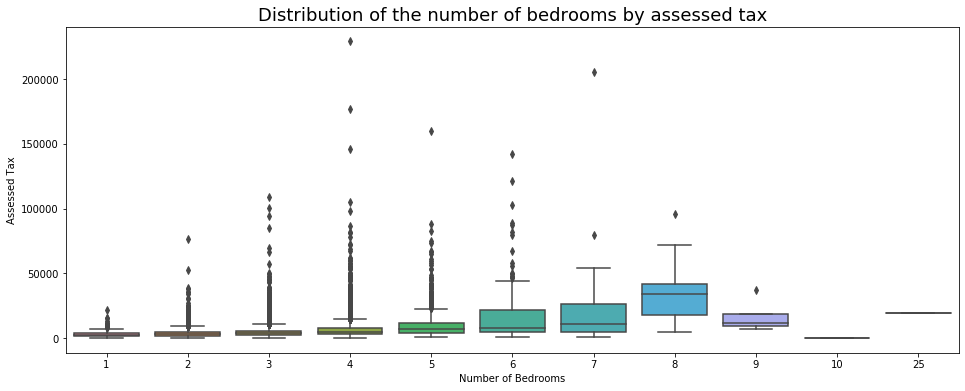

In [11]:
plt.figure(figsize=(16, 6))
ax2 = sns.boxplot(x=df_z["Number of Bedrooms"], y=df_z["Assessed Tax"], data=df_z)\
.set_title('Distribution of the number of bedrooms by assessed tax', fontsize = 18)

#### Histogram of the single-unit square footage - this is a fairly normal distribution with a long tail for mansions

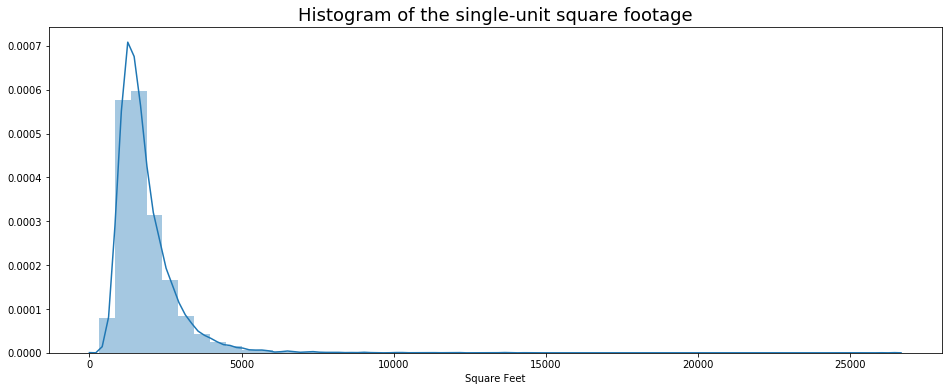

In [12]:
plt.figure(figsize=(16, 6))
ax3 = sns.distplot(df_z['Square Feet'])\
.set_title('Histogram of the single-unit square footage', fontsize = 18)

### Split variables into X and y, then train and test

 #### Remove columns of data not necessary for this phase of the analysis and create a new dataframe for the y variable

In [13]:
X = df_z.drop(columns=['Property Description', 'Tax Appraised Value', 'Assessed Tax', 'County Number'])
y=df_z[['Tax Appraised Value']]

#### Split the modified/new variables into train and test, with 80% of data rows in the two train variables.

In [14]:
x_train, x_test, y_train, y_test = z_split_scale.split_my_data(X,y)

#### Sample of x_train data to verify split and column changes occured

In [15]:
x_train.sample(2)

,Number of Bathrooms,Number of Bedrooms,Square Feet
8609,2.5,3,2248
639,3.0,4,1596


#### Sample of y_test data to verify new column was created and the split occured

In [38]:
y_train.sample(2)

,Tax Appraised Value
2768,605492
2644,7766509


### Visualization of the split x variable

#### Pair plot showing histogram and scatter plot of each combination of x_train variable (i.e. bathrooms, bathrooms and square feet)

Text(0.5, 0.98, 'Histogram and scatter plot for every combinaiton of x_train variable')

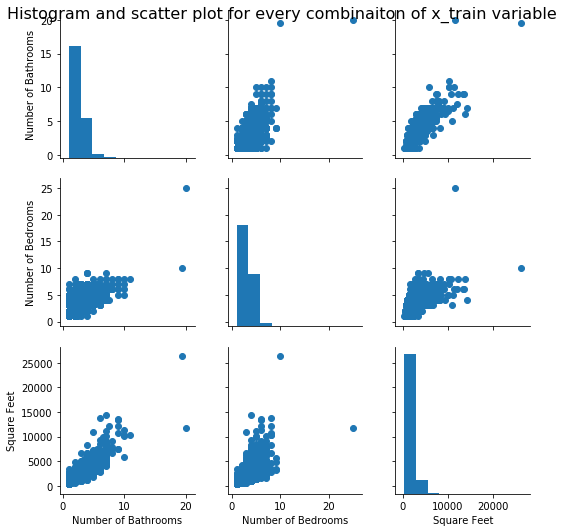

In [17]:
g = sns.PairGrid(x_train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.fig.suptitle('Histogram and scatter plot for every combinaiton of x_train variable', fontsize = 16)

## Apply standard scaler to x_train and x_test

#### Because of assumption that the x (dependent) variables are normally distributed, the standard scaler will be used.

In [18]:
train_x_scaled_data, test_x_scaled_data,scaler_x_train, scaler_x_test = z_split_scale.standard_scaler(x_train,x_test)

#### Verify data scaler has transformed independent variables to harmonize the scales among the variables

In [19]:
train_x_scaled_data.head(2)

,Number of Bathrooms,Number of Bedrooms,Square Feet
8477,0.278822,-0.262844,-0.054008
10275,-0.207660,0.783780,0.016880


# Data modeling

## Run regression on baseline model and 3 models

In [20]:
predictions=pd.DataFrame({'actual':y_train['Tax Appraised Value']}).reset_index(drop=True)

#model 1 - all 3 variables
lm1=LinearRegression()
lm1.fit(train_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms', 'Square Feet']],y_train)
lm1_predictions=lm1.predict(train_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms', 'Square Feet']])
predictions['lm1']=lm1_predictions

#model 2 - just square feet
lm2=LinearRegression()
lm2.fit(train_x_scaled_data[['Square Feet']],y_train)
lm2_predictions=lm2.predict(train_x_scaled_data[['Square Feet']])
predictions['lm2']=lm2_predictions

#model 3 - only number of bedrooms and bathrooms
lm3=LinearRegression()
lm3.fit(train_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms']],y_train)
lm3_predictions=lm3.predict(train_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms']])
predictions['lm3']=lm3_predictions

#baseline model (mean)
predictions['baseline'] = y_train.mean()[0]
predictions.head()

#print(lm1.intercept_,lm1.coef_)

,actual,lm1,lm2,lm3,baseline
0,378038,489000.394632,439752.591875,597899.189244,462043.629601
1,600000,350635.071116,469010.509667,308978.373883,462043.629601
2,274121,544289.115431,860648.637825,517427.056179,462043.629601
3,190192,173113.494416,223661.970469,8181.454481,462043.629601
4,282036,472055.385009,448529.967213,401326.610990,462043.629601


#### Evaluate baseline and 3 models

In [21]:
#Baseline
MSE_baseline = mean_squared_error(predictions.actual, predictions.baseline)
SSE_baseline = MSE_baseline*len(predictions.actual)
RMSE_baseline = sqrt(MSE_baseline)
r2_baseline = r2_score(predictions.actual, predictions.baseline)
print('MSE baseline:', MSE_baseline)
print('SSE baseline:', SSE_baseline)
print('RMSE baseline:', RMSE_baseline)
print('R2 baseline:', r2_baseline)

MSE baseline: 420928611175.0658
SSE baseline: 5375258364705590.0
RMSE baseline: 648790.1133456534
R2 baseline: 0.0


In [22]:
#Model 1: number of bedrooms, number of bathrooms and square feet
MSE_1 = mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print('MSE model 1:', MSE_1)
print('SSE model 1:', SSE_1)
print('RMSE model 1:', RMSE_1)
print('R2 model 1:', r2_1)

MSE model 1: 240025152945.04852
SSE model 1: 3065121203108269.5
RMSE model 1: 489923.6195010897
R2 model 1: 0.4297723020656794


In [23]:
#Model 2: square feet only
MSE_2 = mean_squared_error(predictions.actual, predictions.lm2)
SSE_2 = MSE_2*len(predictions.actual)
RMSE_2 = sqrt(MSE_2)
r2_2 = r2_score(predictions.actual, predictions.lm2)
print('MSE model 2:', MSE_2)
print('SSE model 2:', SSE_2)
print('RMSE model 2:', RMSE_2)
print('R2 model 2:', r2_2)

MSE model 2: 250577596757.9224
SSE model 2: 3199875910598669.0
RMSE model 2: 500577.2635247454
R2 model 2: 0.40470286384570275


In [24]:
#Model 3: bedrooms and bathrooms only
MSE_3 = mean_squared_error(predictions.actual, predictions.lm2)
SSE_3 = MSE_3*len(predictions.actual)
RMSE_3 = sqrt(MSE_3)
r2_3 = r2_score(predictions.actual, predictions.lm3)
print('MSE model 3:', MSE_3)
print('SSE model 3:', SSE_3)
print('RMSE model 3:', RMSE_3)
print('R2 model 3:', r2_3)

MSE model 3: 250577596757.9224
SSE model 3: 3199875910598669.0
RMSE model 3: 500577.2635247454
R2 model 3: 0.2954275801853904


### *** The model with number of bedrooms/bathrooms and square feet performed the best. ***

### Apply model to test data

In [39]:
model=lm1.predict(test_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms', 'Square Feet']])
model=model.ravel().reshape(3193)
y_test1=np.array(y_test).ravel().reshape(3193)
best_model=pd.DataFrame({'predictions':model,'Tax Appraised Value':y_test1})

best_model.head()

,predictions,Tax Appraised Value
0,106165.483511,208546
1,43677.550912,137176
2,610147.127835,227220
3,774899.441594,220308
4,73182.027680,395686


### Function that creates the model object, fits and predicts, given X_train, X_test, y_train, y_test

In [49]:
X_train1 = train_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms', 'Square Feet']]
X_test1 = test_x_scaled_data[['Number of Bathrooms', 'Number of Bedrooms', 'Square Feet']]
def modeling_function(X_train1, X_test1,y_train,y_test):
    predictions_train=pd.DataFrame({'actual': y_train["Tax Appraised Value"]}).reset_index(drop=True)
    print(predictions_train)
    predictions_test=pd.DataFrame({'actual': y_test["Tax Appraised Value"]}).reset_index(drop=True)
        
    #model 1
    lm1=LinearRegression()
    lm1.fit(train_x_scaled_data,y_train)
    lm1_predictions=lm1.predict(train_x_scaled_data)
    predictions_train['lm1']=lm1_predictions

    #model 2
    lm2=LinearRegression()
    lm2.fit(test_x_scaled_data,y_test)
    lm2_predictions=lm2.predict(test_x_scaled_data)
    predictions_test['lm2']=lm2_predictions
    
    #model 3
    lm3=LinearRegression()
    lm3.fit(test_x_scaled_data,y_test)
    lm3_predictions=lm3.predict(test_x_scaled_data)
    predictions_test['lm3']=lm3_predictions
    
    return predictions_train,predictions_test

In [53]:
model_train, model_test = modeling_function(X_train1, X_test1, y_train, y_test)

        actual
0       378038
1       600000
2       274121
3       190192
4       282036
5        91911
6       712558
7       235895
8       108060
9       393900
10      320414
11      164352
12      463417
13      249654
14      207901
15      582000
16      299690
17      266321
18       87019
19      847409
20     1748575
21      304716
22      330455
23      490682
24      226328
25      201000
26      299860
27      475330
28      343953
29      244037
...        ...
12740   417622
12741    22520
12742    79222
12743   290733
12744   468122
12745   102809
12746   122876
12747   259935
12748   517938
12749   285007
12750    51872
12751    67463
12752   763725
12753   318218
12754   610262
12755   440247
12756   115029
12757   563463
12758   372923
12759   215765
12760   227199
12761    51476
12762   221331
12763   347259
12764   101068
12765   455620
12766   104266
12767    80102
12768   126286
12769   297133

[12770 rows x 1 columns]


In [54]:
print(model_train.head(2))
print(model_test.head(2))

   actual            lm1
0  378038  489000.394632
1  600000  350635.071116
   actual            lm2            lm3
0  208546  110335.050975  110335.050975
1  137176   69330.714266   69330.714266


Predicted values for y_train given the linear regression model

In [ ]:
y_pred_lm1 = lm1.predict(train_x_scaled_data)
y_pred_lm1

In [ ]:
res = sm.OLS(y_test, test_x_scaled_data).fit()
res.summary()

## Distribution of tax rates for each county

In [ ]:
df_z['County Tax Rates'] = df_z['Assessed Tax']/df_z['Tax Appraised Value']

In [ ]:
df_z.head()

In [ ]:
v = df_z[df_z['County Number'] == 6111]
l = df_z[df_z['County Number'] == 6037]
o = df_z[df_z['County Number'] == 6059]

In [ ]:
plt.figure(figsize=(16, 6))
plt.suptitle('Distribution of Tax Rates by County (per $ of Assessed Value)', fontsize=14)

plt.subplot(331)
sns.distplot(l['County Tax Rates'])
plt.title('Los Angeles')

plt.subplot(332)
sns.distplot(o['County Tax Rates'])
plt.title('Orange')

plt.subplot(333)
sns.distplot(v['County Tax Rates'])
plt.title('Ventura')
plt.show()

In [ ]:
Los_Angeles_County = l.describe()
Los_Angeles_County

In [ ]:
Orange_County = o.describe()
Orange_County

In [ ]:
Ventura_County = v.describe()
Ventura_County